In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)
torch.cuda.empty_cache()

## Data Loading and Preprocessing

Loading the dataset and resizing it to 224 size image as Resnet-34.


In [10]:
#Load the dataset and transform into tensors
from torchvision import datasets, transforms

dataset_path=datasets.ImageFolder(root='fruits/Training/',
                                 transform=transforms.Compose(
                                     [
                                         transforms.Resize(224),
                                         transforms.ToTensor()
                                     ]
                                 )
                                )

## Spliting dataset into train and test (80% training and 20% Test)

In [19]:
from torch.utils.data.sampler import SubsetRandomSampler

split = int(0.8* len(dataset_path))
index_list = list(range(len(dataset_path)))
np.random.shuffle(index_list)

train_idx, test_idx = index_list[:split], index_list[split:]

## create sample objects using SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

## create iterator objects for train and test datasets
train_loader = torch.utils.data.DataLoader(dataset_path, 
                                           batch_size = 16,
                                           sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset_path, 
                                           batch_size = 16,
                                           sampler=test_sampler)

print(f'Total Number of Examples: {len(dataset_path)}')
print(f'Number of training Examples: {len(train_sampler)}')
print(f'Number of testing Examples: {len(test_sampler)}')

Total Number of Examples: 8166
Number of training Examples: 6532
Number of testing Examples: 1634


In [20]:
Classes_num=len(train_loader.dataset.classes)
print(f'Number of Classes: {Classes_num}')
print(f'Classes Name: {train_loader.dataset.classes}')

Number of Classes: 15
Classes Name: ['Rambutan', 'Raspberry', 'Redcurrant', 'Salak', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato 2', 'Tomato 3', 'Tomato 4', 'Tomato Cherry Red', 'Tomato Maroon', 'Walnut']


Example: 
(224, 224, 3)


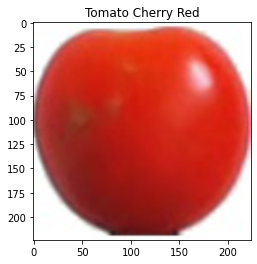

In [21]:
print("Example: ")
i1, l1 = next(iter(train_loader))
plt.title(train_loader.dataset.classes[l1[0]])
plt.imshow(np.array(i1[0].permute(1,2,0)));
print(np.array(i1[0].permute(1,2,0)).shape)

# Convolutional Neural Network (Resnet-34)

Resnet use new architecture in CNN where It add previous information to upcomming next layer by a new path, With ResNets, the gradients can flow directly through the skip connections backwards from later layers to initial filters.


Since ResNets can have variable sizes, depending on how big each of the layers of the model are, and how many layers it has, we will use the Resnet-34 as described by the authors in the [paper ResNet 34](https://arxiv.org/abs/1512.03385) .


We will import already made Resnet34 models from torch vision library.

In [22]:
import torchvision.models as models
model = models.resnet34(num_classes=Classes_num)
model.cuda(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

Define the loss function and the optimizer using the nn and optim package:

In [23]:
import torch.nn as nn
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## Model Training

In [24]:
epochs = 10
loss_array = []

for epoch in range(1, epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        
        #set the gradients to zero 
        #before starting to do backpropragation
        optimizer.zero_grad() 
        
        ## 1. forward propagation
        model_out = model(data)
        
        ## 2. loss calculation
        loss = criterion(model_out, target)
        
        ## 3. backward propagation
        loss.backward()
        
        ## 4. weight optimization
        optimizer.step()
        
        loss_array.append(loss.item())
        if batch_idx % len(train_loader)-1 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 1, Loss: 2.9308483600616455
Epoch 2, Loss: 0.012513965368270874
Epoch 3, Loss: 0.02767091989517212
Epoch 4, Loss: 0.01997232437133789
Epoch 5, Loss: 0.00043392181396484375
Epoch 6, Loss: 0.05350005626678467
Epoch 7, Loss: 0.000507354736328125
Epoch 8, Loss: 0.0070490241050720215
Epoch 9, Loss: 0.0059642493724823


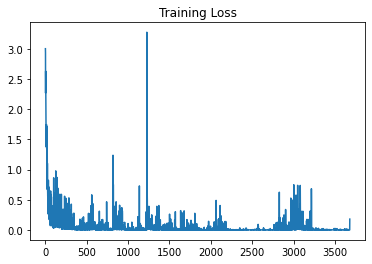

In [25]:
%matplotlib inline
plt.plot(loss_array)
plt.title("Training Loss")
plt.show()

## Model Testing

In [26]:
dataiter = iter(test_loader)
data, labels = dataiter.next()
data, target = Variable(data).to(device), Variable(target).to(device)

output = model(data)
_, preds_tensor = torch.max(output, 1)
preds_tensor=preds_tensor.cpu()
preds = np.squeeze(preds_tensor.numpy())
print(f'Actual: {np.array(labels[:10])}')
print(f'Predicted: {preds[:10]}')

Actual: [ 2 13 10  3 10  8  0 13  9  8]
Predicted: [ 2 13 10  3 10  8  0 13  9  8]


In [27]:
correct = 0
test_loss = 0

for data, target in test_loader:
    data, target = Variable(data).to(device), Variable(target).to(device)
    net_out = model(data)
    
    test_loss += criterion(net_out, target).item()
    pred = net_out.data.max(1)[1] #get index of the max log-probability
    correct += pred.eq(target.data).sum()
    
test_loss /= len(test_loader.dataset)

print(f'Average loss: {test_loss}')
print(f'Accuracy: {np.array(100.*correct.cpu() / len(test_sampler))}%')
print(f'Total Test Examples: {len(test_sampler)}')
print(f'Correct predicted examples: {int(correct)}')

Average loss: 3.9456964648590346e-05
Accuracy: 99%
Total Test Examples: 1634
Correct predicted examples: 1633
